In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [41]:
import tensorflow as tf

In [42]:
train_dir="/kaggle/input/cats-and-dogs/cats_and_dogs_filtered/train"
val_dir="/kaggle/input/cats-and-dogs/cats_and_dogs_filtered/test"

In [43]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128,128),
    batch_size=128,
    label_mode='binary'
)
val_ds=tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(128,128),
    batch_size=128,
    label_mode='binary'
)

Found 2752 files belonging to 2 classes.
Found 248 files belonging to 2 classes.


In [44]:
rescale_layer=tf.keras.layers.Rescaling(scale=1./255)
train_scaled=train_ds.map(lambda image,label:(rescale_layer(image),label))
val_scaled=val_ds.map(lambda image,label:(rescale_layer(image),label))

In [45]:
train_final=(train_scaled.cache().shuffle(buffer_size=300).prefetch(buffer_size=tf.data.AUTOTUNE))
val_final=(val_scaled.cache().prefetch(buffer_size=tf.data.AUTOTUNE))

In [46]:
input_shape = (128,128,3)
augemented_layers=tf.keras.Sequential([
    	tf.keras.Input(shape=input_shape),
        tf.keras.layers.RandomFlip(0.2),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomTranslation(0.1,0.1,fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.1)
    ])

In [47]:
from tensorflow.keras import regularizers,layers
model = tf.keras.Sequential([
    tf.keras.Input(shape=(128,128,3)),
    augemented_layers,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [48]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs['accuracy'] >= 0.9 and logs['val_accuracy'] >= 0.8:
            self.model.stop_training = True
            print("Done")

In [50]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#     ModelCheckpoint('best_model.h5', save_best_only=True)
# ]

In [51]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [52]:
history = model.fit(
    train_final,
    epochs=100,
    validation_data=val_final,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5201 - loss: 0.7653 - val_accuracy: 0.6048 - val_loss: 0.6856
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5522 - loss: 0.6875 - val_accuracy: 0.5685 - val_loss: 0.6802
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6221 - loss: 0.6647 - val_accuracy: 0.5605 - val_loss: 0.6687
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6300 - loss: 0.6400 - val_accuracy: 0.6089 - val_loss: 0.6441
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6676 - loss: 0.6200 - val_accuracy: 0.5887 - val_loss: 0.7143
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7006 - loss: 0.5861 - val_accuracy: 0.6492 - val_loss: 0.6253
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6999 - loss: 0.5757 - val_accuracy: 0.6250 - val_loss: 0.6364
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6932 - loss: 0.5811 - val_accuracy: 0.

In [57]:
from tensorflow.keras.models import load_model

# model = load_model('/kaggle/working/best_model.h5')
val_loss, val_acc = model.evaluate(val_final)
print(f'Validation loss: {val_loss}, Accuracy: {val_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8059 - loss: 0.5016
Validation loss: 0.4993020296096802, Accuracy: 0.8104838728904724


In [58]:
preds = model.predict(val_final)
print(preds[:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.00534312]
 [0.82894474]
 [0.54247844]
 [0.9991585 ]
 [0.5362478 ]]


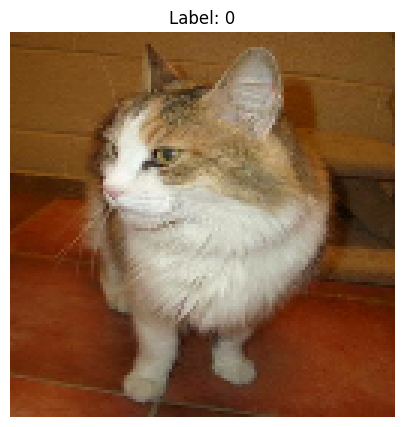

In [59]:
import matplotlib.pyplot as plt
for batch_images, batch_labels in val_final.take(1):
    plt.figure(figsize=(5,5))
    plt.imshow(batch_images[0].numpy())
    plt.title(f"Label: {int(batch_labels[0])}")
    plt.axis('off')
    plt.show()
    break

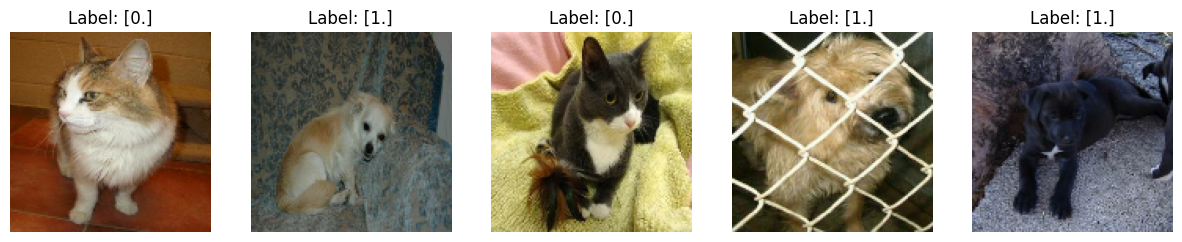

In [60]:
for images, labels in val_final.take(1):
    first_five_images = images[:5]
    first_five_labels = labels[:5]
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(first_five_images[i].numpy())
    plt.title(f"Label: {first_five_labels[i].numpy()}")
    plt.axis('off')
plt.show()

In [61]:
model.save('ML 0001- Khin Myat Noe_model.h5')